In [4]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [29]:
img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 0

num_classes = 3

max_epochs = 500

net_in_dims = 2
net_in_channels = 4

net_channels=(32, 64, 128)
net_strides=(2, 2)
        
num_folds = 15

num_slices = 32
size_x = 160
size_y = 320

roi_size = (size_x,size_y)

num_workers_te = 0
batch_size_te = 1

model_filename_base = "./results/BAMC_PTX_ARUNet-3D-Middle-StdDevExtended-ExtrudedNS"

num_images = len(all_images)
print(num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62 62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


In [37]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [38]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

tensor(1.)
Data Size = torch.Size([1, 1, 160, 320])


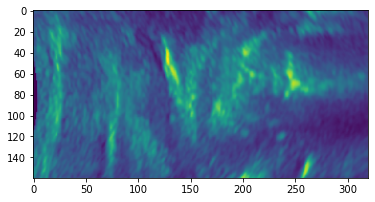

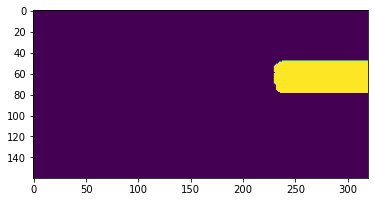

In [39]:
batchnum = 0
imgnum = 0
lbl = utils.first(test_loader[batchnum])["label"]
m = lbl[imgnum,0,:,:].max()
print(m)
if m == 1:
    img = utils.first(test_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:])
print("Data Size =", lbl.shape)

In [40]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [47]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, min_portion_comp, p_prior, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
    
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dims,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:22]!=prevfname[:22]:
                        #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
                        if count1 == count:
                            if graph:
                                print("  Winner = Sliding")
                            if prevfname[3] == 's':
                                correct += 1
                            else:
                                incorrect += 1
                                false_negatives += 1
                                print(" FN Patient =", prevfname)
                        else:
                            if graph:
                                print("  Winner = Not Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                                print(" FP Patient =", prevfname)
                        if graph:
                            print()
                            print()
                        count1 = 0
                        count = 0
                    
                    prob_shape = test_outputs[j,:,:,:].shape
                    prob = np.empty(prob_shape)
                    for c in range(num_classes):
                        itkProb = itk.GetImageFromArray(test_outputs[j,c,:,:].cpu())
                        imMathProb = ttk.ImageMath.New(itkProb)
                        imMathProb.Blur(5)
                        itkProb = imMathProb.GetOutput()
                        prob[c] = itk.GetArrayFromImage(itkProb)
                    arrc1 = np.zeros(prob[0].shape)
                    if False:
                        arrc1 = np.argmax(prob,axis=0)
                    else:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = min(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        for c in range(num_classes):
                            prob[c] = prob[c] * p_prior[c]
                        arrc1 = np.argmax(prob,axis=0)
                    
                    max_size = np.count_nonzero(test_data["label"][j, 0, :, :].cpu()>0)
                    min_thresh = max(min_size_comp, max_size*min_portion_comp)
                    
                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    for c in range(num_classes):
                        imMathC1.Erode(10,c,0)
                        imMathC1.Dilate(10,c,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    slice_count1 = np.count_nonzero(arrc1==1)
                    slice_count2 = np.count_nonzero(arrc1==2)
                    slice_decision = "Unknown"
                    slice_message = "Correct"
                    if slice_count2>slice_count1 and slice_count2>min_thresh:
                        count1 += 1
                        slice_decision = "Sliding"
                        if fname[3] == 's':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_false_negatives += 1
                            slice_message = "False Negative"
                    else:
                        slice_decision = "Not Sliding"
                        if fname[3] == 'n':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_message = "Fales Positive"
                    count += 1
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {i}")
                        tmpV = test_data["image"][j, 0, :, :]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {i}")
                        tmpV = test_data["label"][j, 0, :, :]
                        tmpV[0,0]=1
                        tmpV[0,1]=2
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {i}")
                        arrc1[0,0]=1
                        arrc1[0,1]=2
                        plt.imshow(arrc1[:,:])
                        plt.show()

                        print("Number of not-sliding / sliding pixel =", slice_count1, slice_count2)
                        print("    Min thresh =", min_thresh)
                        print("   ", slice_decision, "=", slice_message)
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[j,c,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".nii.gz"
                            itk.imwrite(itkimg, filename)
                    
                    i += 1
                    
            #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print(" FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print(" FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

*************
Prior = [1.3, 1.0, 0.85]
   VFOLD = 0 of 15


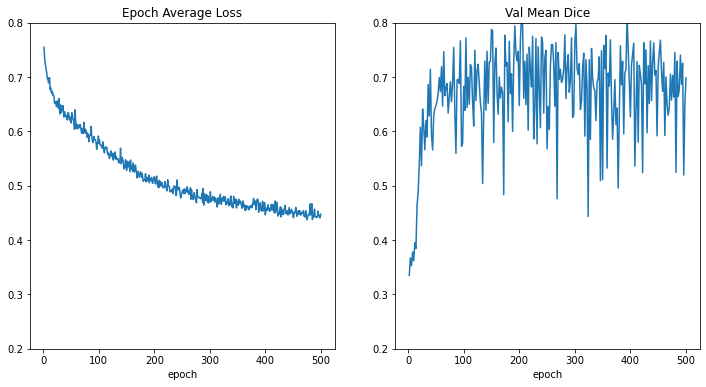

247ns_image_2734882394424_CLEAN.nii.gz


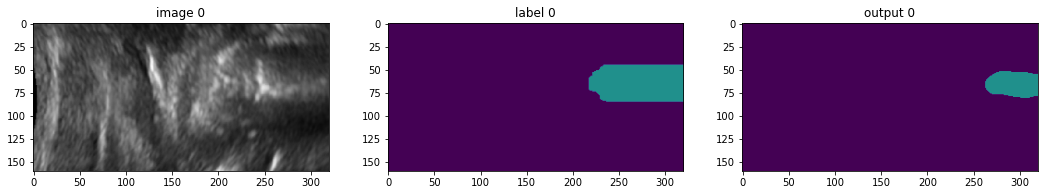

Number of not-sliding / sliding pixel = 1389 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


247ns_image_2743083265515_CLEAN.nii.gz


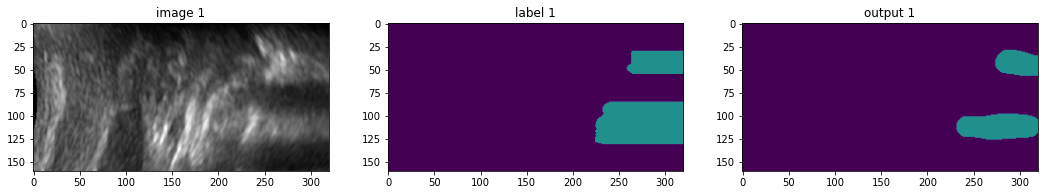

Number of not-sliding / sliding pixel = 3184 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


236s_iimage_1139765223418_CLEAN.nii.gz


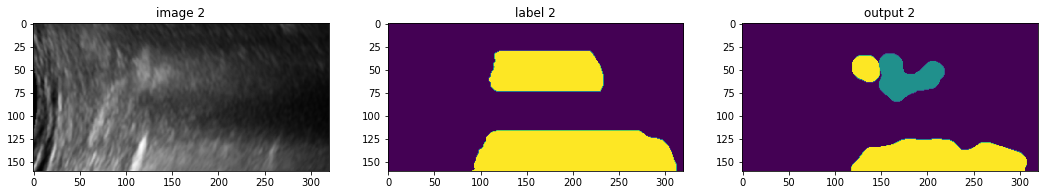

Number of not-sliding / sliding pixel = 2218 5957
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


236s_iimage_1327616672148_clean.nii.gz


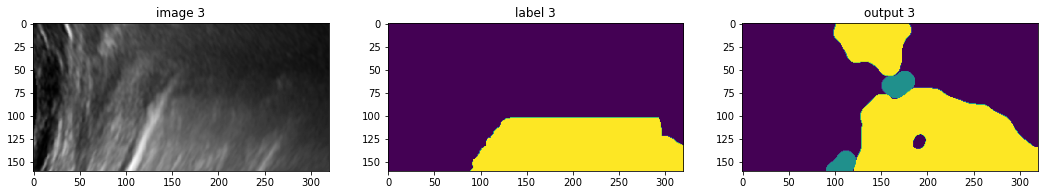

Number of not-sliding / sliding pixel = 1262 16928
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


237s_iimage_24164968068436_CLEAN.nii.gz


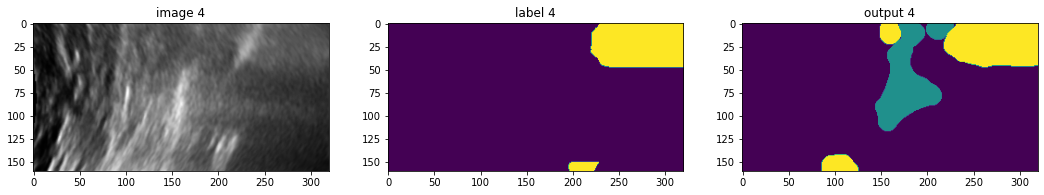

Number of not-sliding / sliding pixel = 4536 5433
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 1 of 15


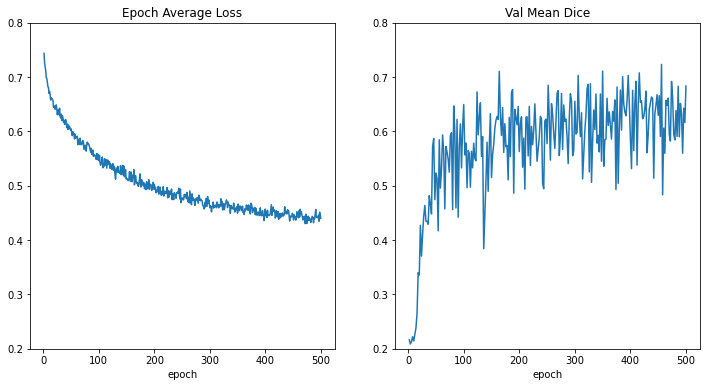

025ns_Image_262499828648_clean.nii.gz


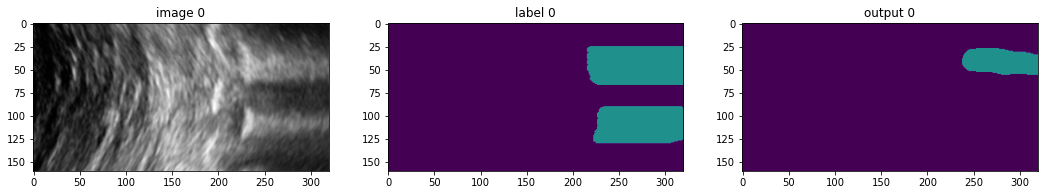

Number of not-sliding / sliding pixel = 1998 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


025ns_image_267456908021_clean.nii.gz


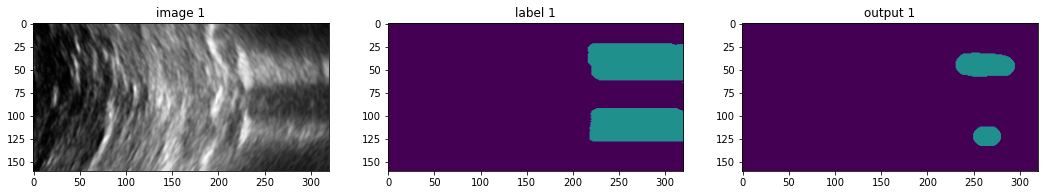

Number of not-sliding / sliding pixel = 1942 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


004s_iimage_73815992352100_clean.nii.gz


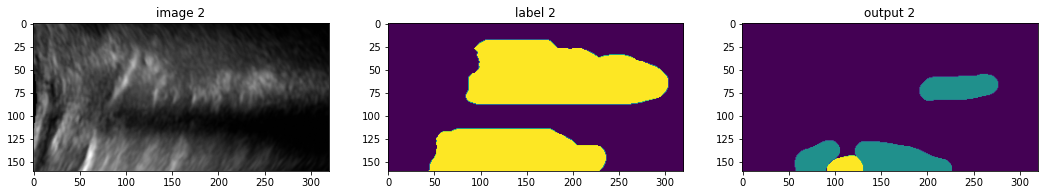

Number of not-sliding / sliding pixel = 5582 528
    Min thresh = 1000
    Not Sliding = Fales Positive


  Winner = Not Sliding
 FP Patient = 004s_iimage_73815992352100_clean.nii.gz


004s_iimage_74132233134844_clean.nii.gz


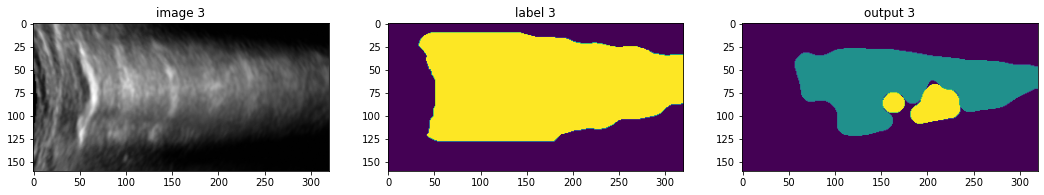

Number of not-sliding / sliding pixel = 14276 2031
    Min thresh = 1000
    Not Sliding = Fales Positive


  Winner = Not Sliding
 FP Patient = 004s_iimage_74132233134844_clean.nii.gz


   VFOLD = 2 of 15


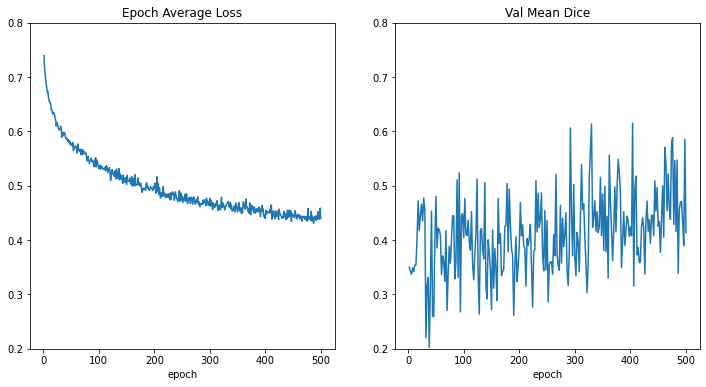

026ns_image_1083297968960_clean.nii.gz


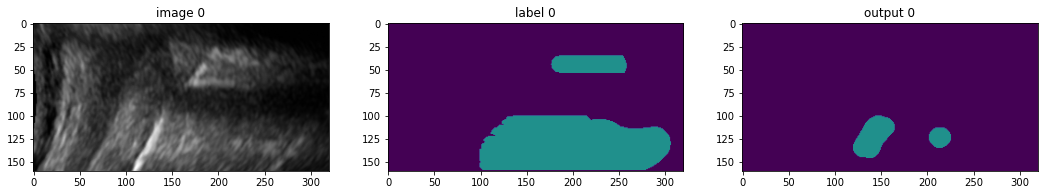

Number of not-sliding / sliding pixel = 1743 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


026ns_image_1087766719219_clean.nii.gz


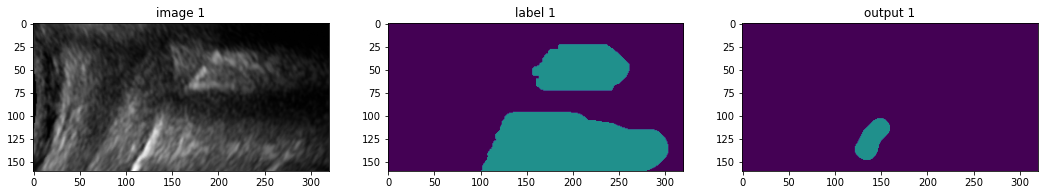

Number of not-sliding / sliding pixel = 1019 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


019s_iimage_10705997566592_CLEAN.nii.gz


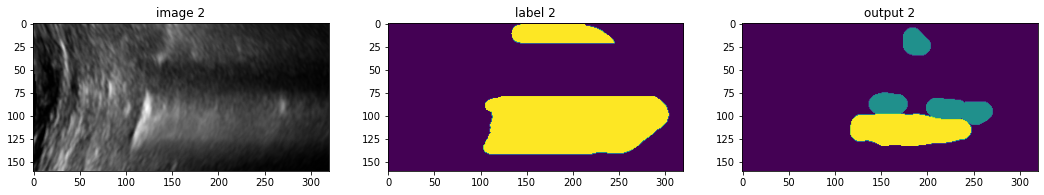

Number of not-sliding / sliding pixel = 3011 3783
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


019s_iimage_10891015221417_clean.nii.gz


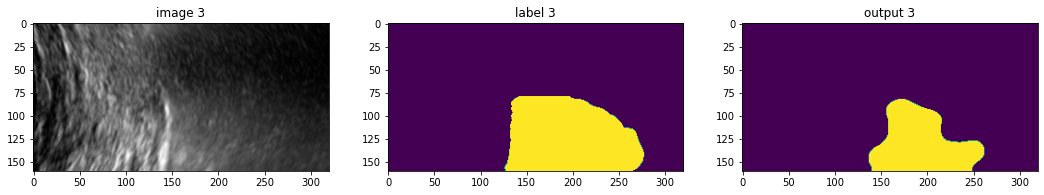

Number of not-sliding / sliding pixel = 0 6083
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 3 of 15


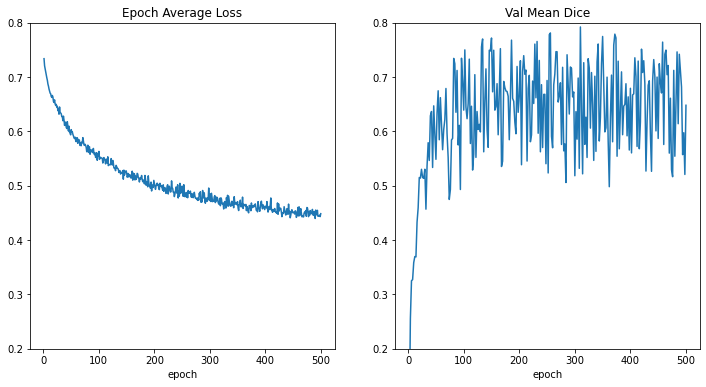

027ns_image_4641643404894_CLEAN.nii.gz


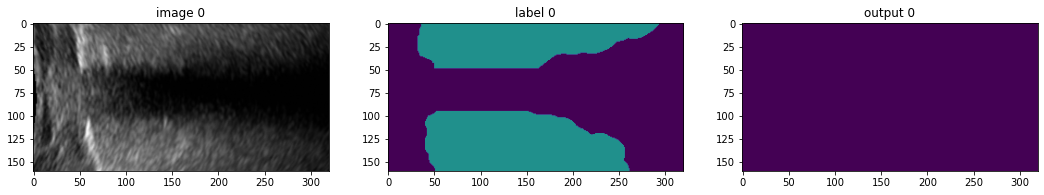

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


027ns_image_4743880599022_clean.nii.gz


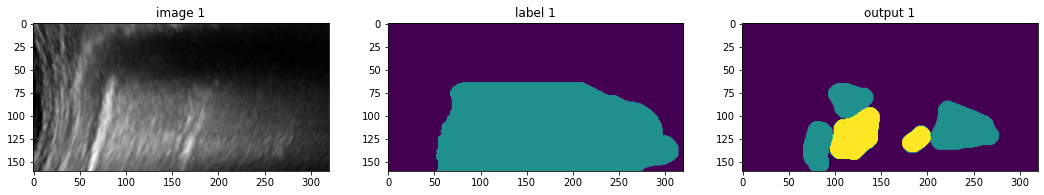

Number of not-sliding / sliding pixel = 5557 2859
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


030s_iimage_1180496934444_clean.nii.gz


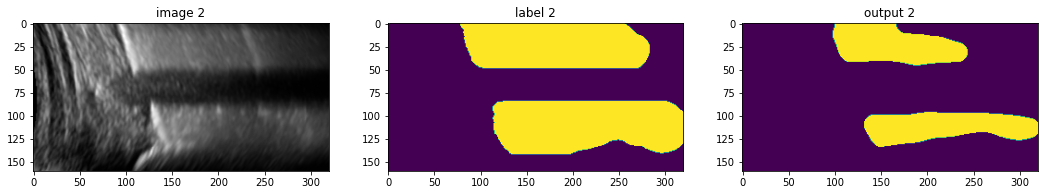

Number of not-sliding / sliding pixel = 0 9898
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


030s_iimage_677741729740_clean.nii.gz


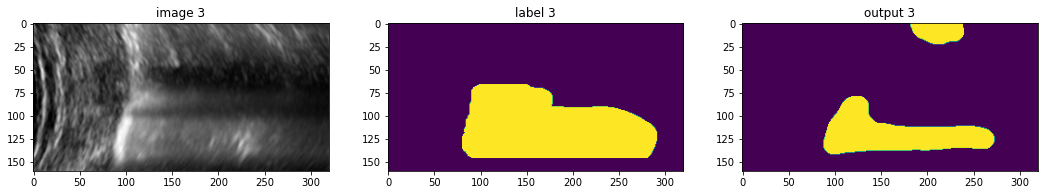

Number of not-sliding / sliding pixel = 0 6989
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 4 of 15


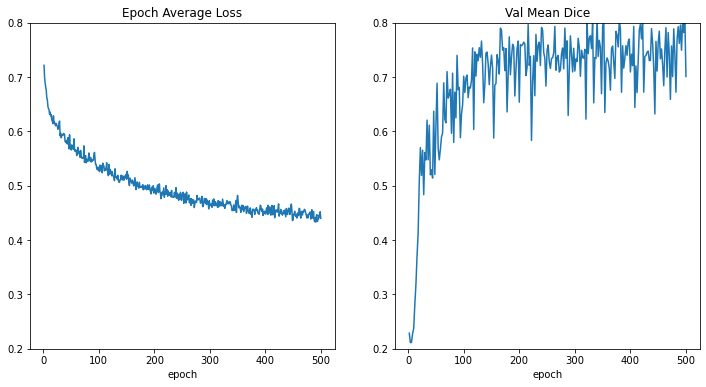

035ns_image_1394469579519_clean.nii.gz


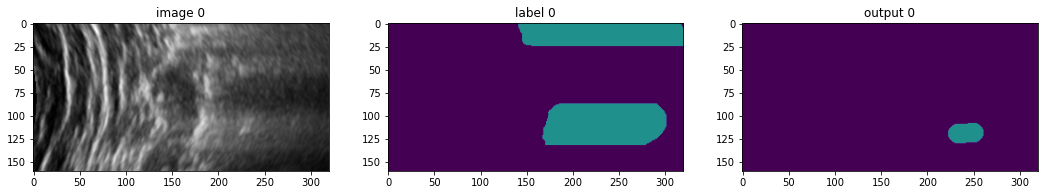

Number of not-sliding / sliding pixel = 704 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


035ns_image_1404802450036_clean.nii.gz


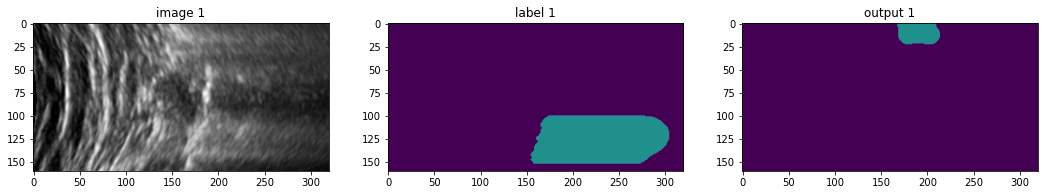

Number of not-sliding / sliding pixel = 954 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


034s_iimage_3368391807672_clean.nii.gz


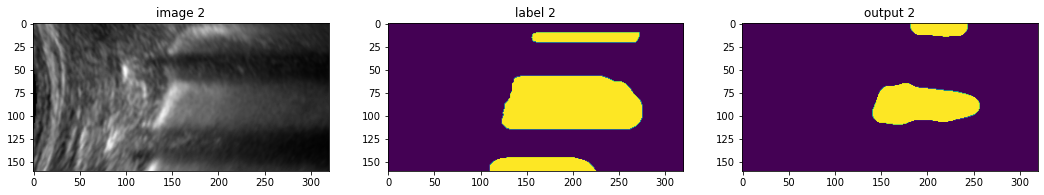

Number of not-sliding / sliding pixel = 0 4644
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


034s_iimage_3401832241774_clean.nii.gz


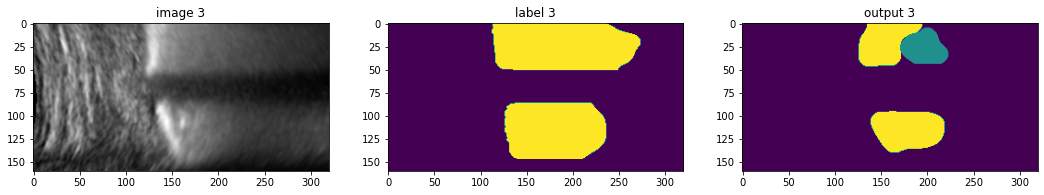

Number of not-sliding / sliding pixel = 1485 5126
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 5 of 15


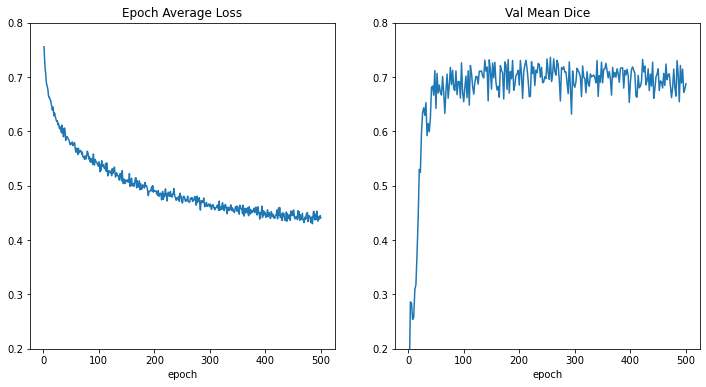

048ns_image_1543571117118_clean.nii.gz


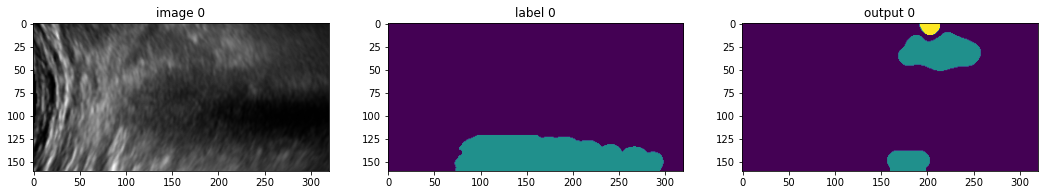

Number of not-sliding / sliding pixel = 3569 231
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


048ns_image_1749559540112_clean.nii.gz


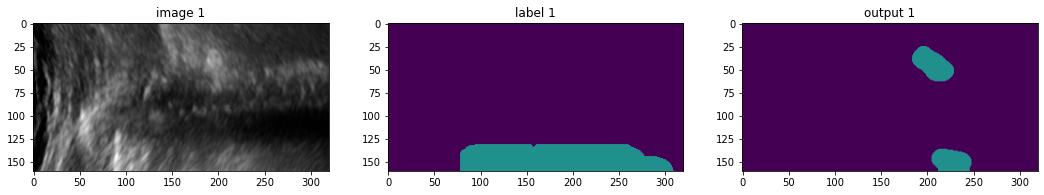

Number of not-sliding / sliding pixel = 1959 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


037s_iimage_588413346180_CLEAN.nii.gz


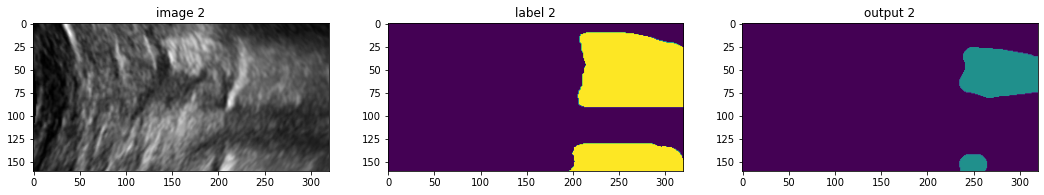

Number of not-sliding / sliding pixel = 4400 0
    Min thresh = 1000
    Not Sliding = Fales Positive


  Winner = Not Sliding


   VFOLD = 6 of 15


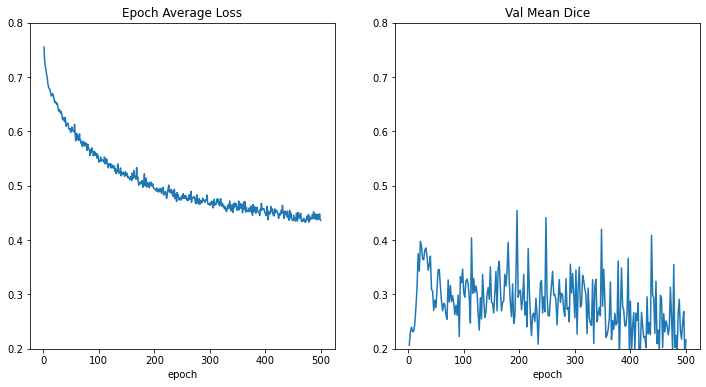

055ns_image_27180764486244_CLEAN.nii.gz


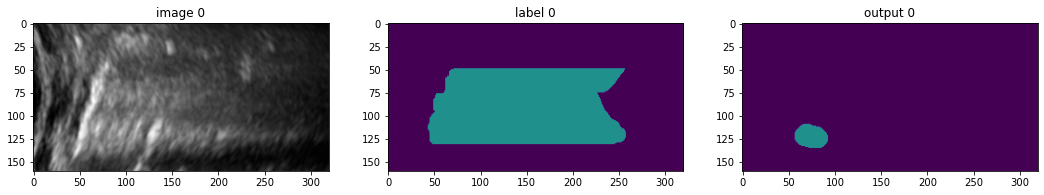

Number of not-sliding / sliding pixel = 739 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


055ns_image_27185428518326_CLEAN.nii.gz


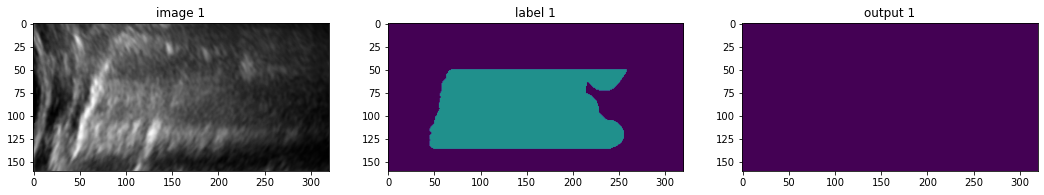

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


043s_iimage_10391571128899_CLEAN.nii.gz


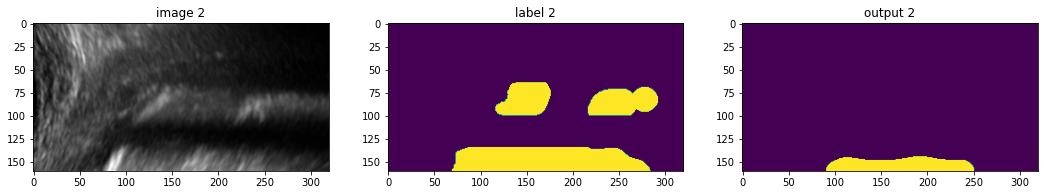

Number of not-sliding / sliding pixel = 0 2051
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


043s_iimage_10395655826502_CLEAN.nii.gz


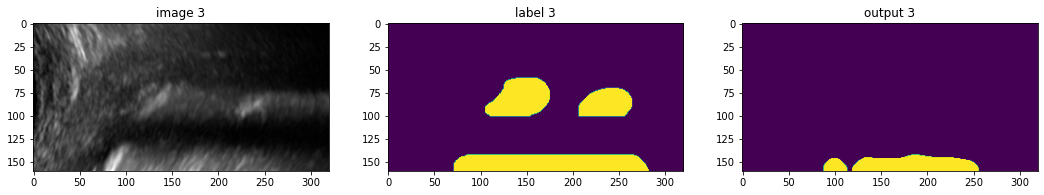

Number of not-sliding / sliding pixel = 0 2213
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 7 of 15


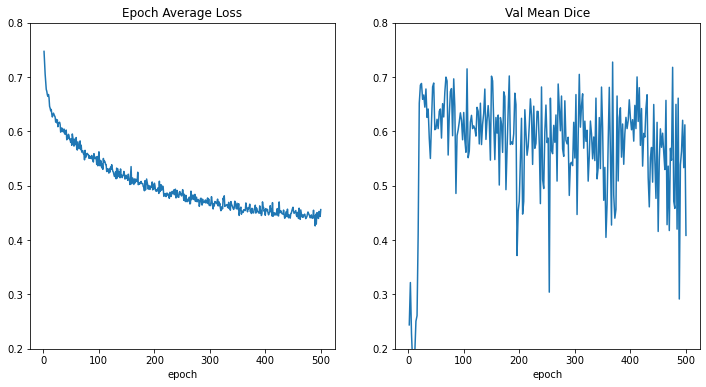

117ns_image_417221672548_CLEAN.nii.gz


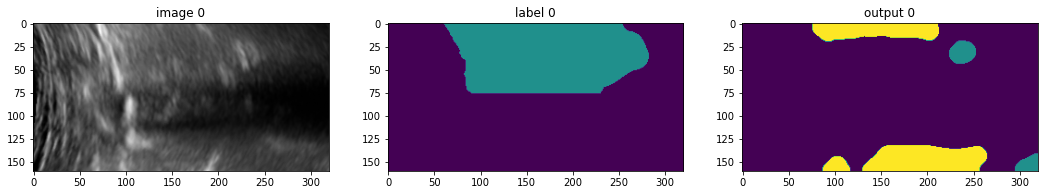

Number of not-sliding / sliding pixel = 926 5842
    Min thresh = 1000
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 117ns_image_417221672548_CLEAN.nii.gz


117ns_image_426794579576_CLEAN.nii.gz


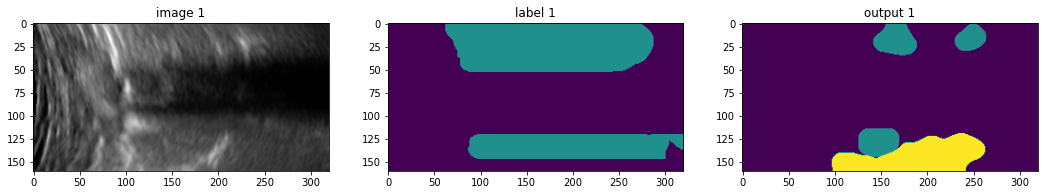

Number of not-sliding / sliding pixel = 3131 4381
    Min thresh = 1000
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 117ns_image_426794579576_CLEAN.nii.gz


065s_iimage_1896534330004_clean.nii.gz


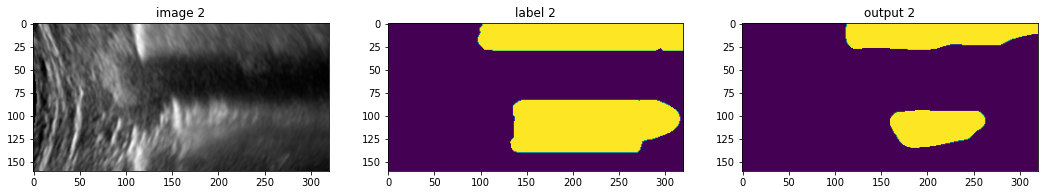

Number of not-sliding / sliding pixel = 0 8352
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


065s_iimage_1901852337971_clean.nii.gz


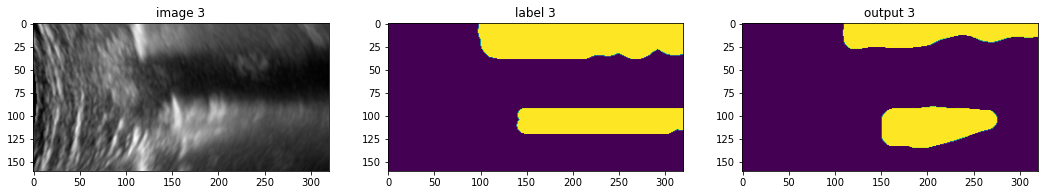

Number of not-sliding / sliding pixel = 0 8806
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 8 of 15


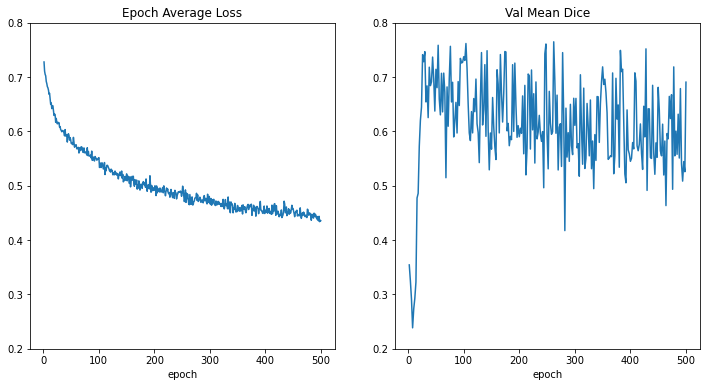

135ns_image_2418161753608_clean.nii.gz


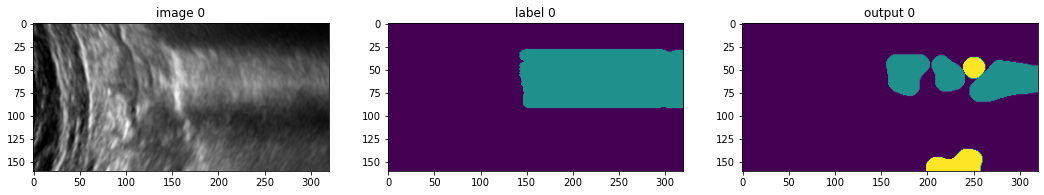

Number of not-sliding / sliding pixel = 5109 1494
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


135ns_image_2454526567135_CLEAN.nii.gz


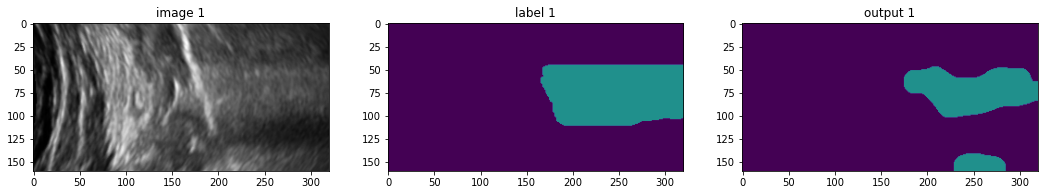

Number of not-sliding / sliding pixel = 6415 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


081s_iimage_2959672151786_clean.nii.gz


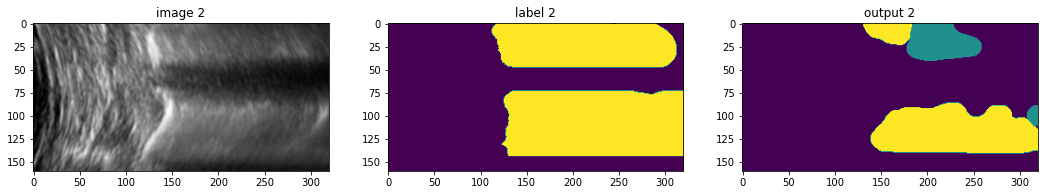

Number of not-sliding / sliding pixel = 2805 8936
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


081s_iimage_3320344386805_clean.nii.gz


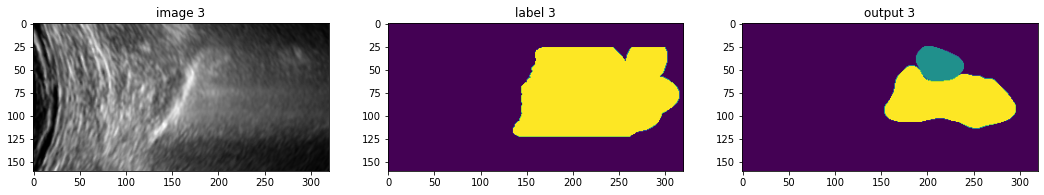

Number of not-sliding / sliding pixel = 1478 6433
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 9 of 15


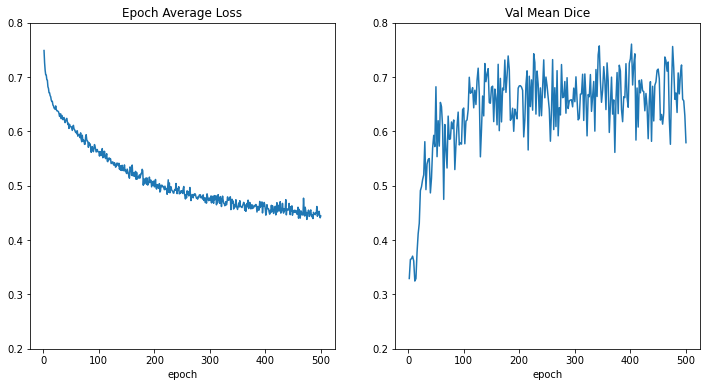

193ns_image_634125159704_CLEAN.nii.gz


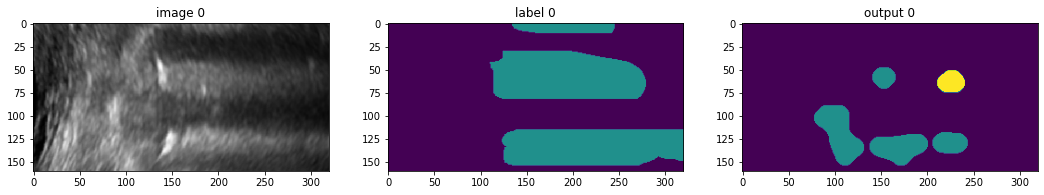

Number of not-sliding / sliding pixel = 4659 583
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


193ns_image_642169070951_clean.nii.gz


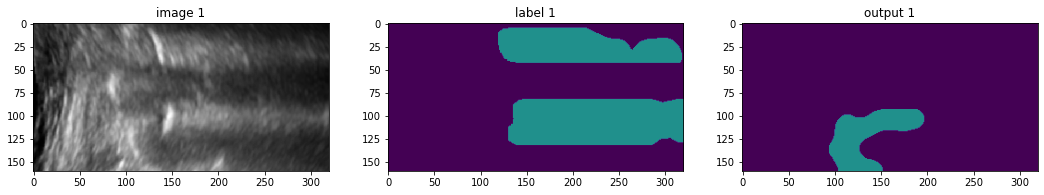

Number of not-sliding / sliding pixel = 3554 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


206s_iimage_1499268364374_clean.nii.gz


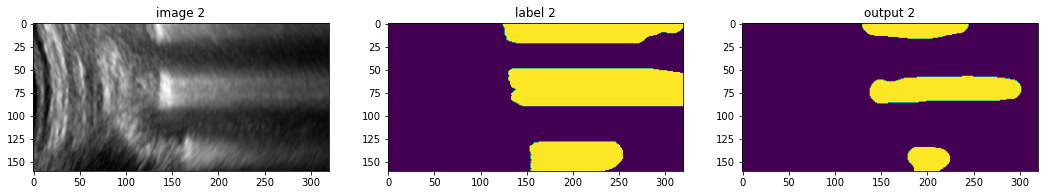

Number of not-sliding / sliding pixel = 0 6693
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


206s_iimage_1511338287338_clean.nii.gz


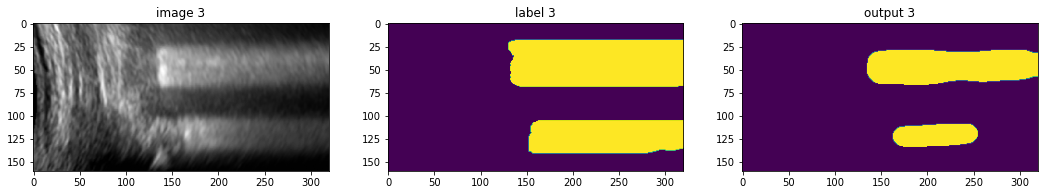

Number of not-sliding / sliding pixel = 0 8216
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 10 of 15


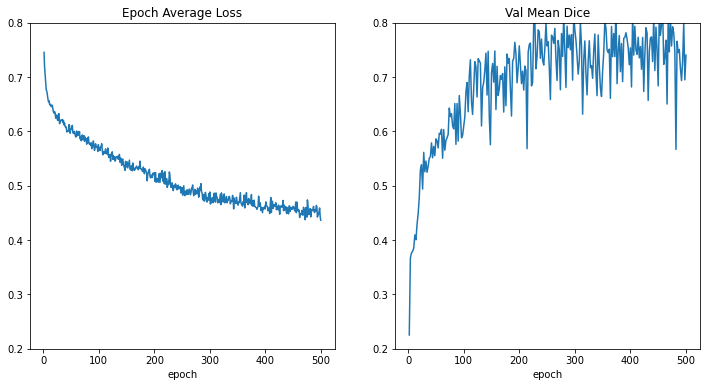

210ns_image_603665940081_clean.nii.gz


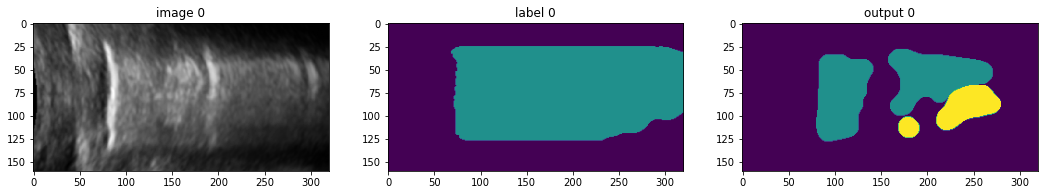

Number of not-sliding / sliding pixel = 9183 2572
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


210ns_image_614587120545_clean.nii.gz


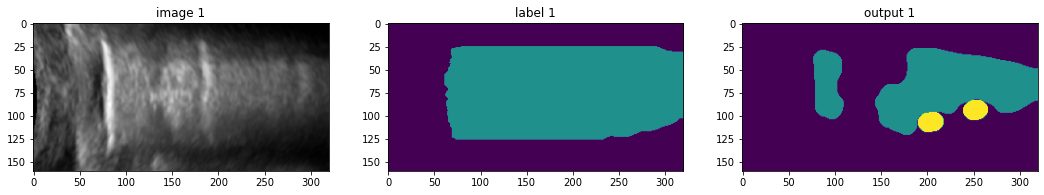

Number of not-sliding / sliding pixel = 11820 983
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


208s_iimage_104543812690743_CLEAN.nii.gz


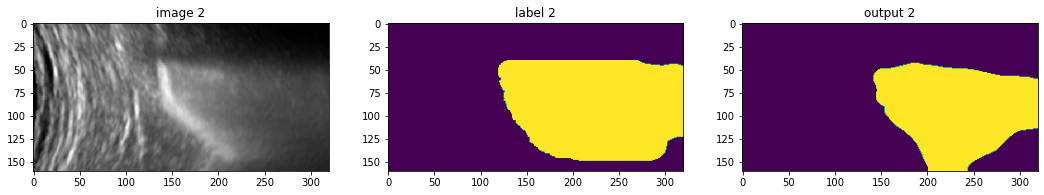

Number of not-sliding / sliding pixel = 0 14502
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


208s_iimage_104548309385533_CLEAN.nii.gz


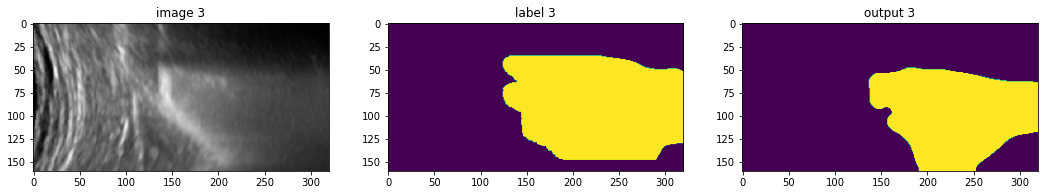

Number of not-sliding / sliding pixel = 0 14674
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


208s_iimage_104932526155699_CLEAN.nii.gz


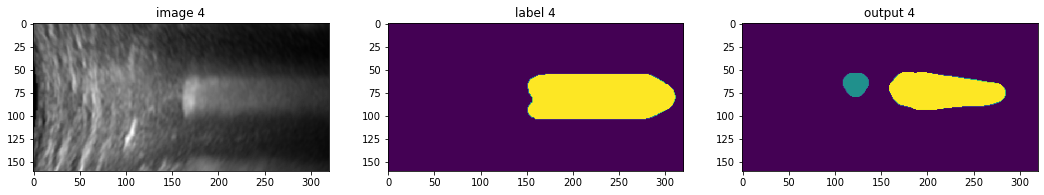

Number of not-sliding / sliding pixel = 574 3944
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 11 of 15


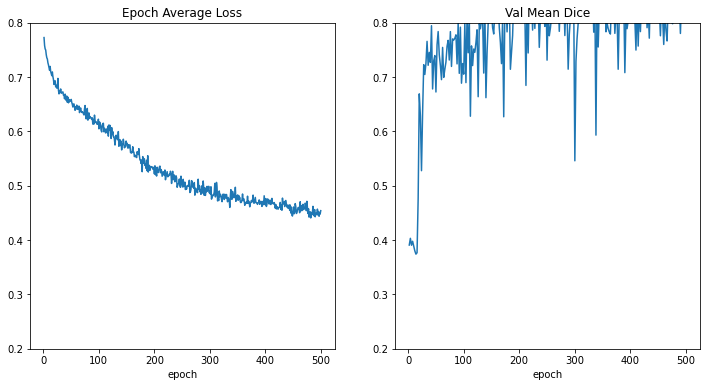

215ns_image_573611404207_CLEAN.nii.gz


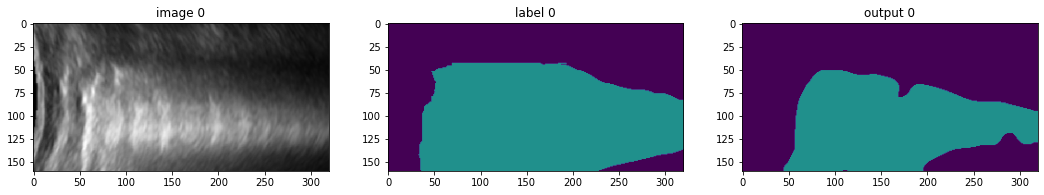

Number of not-sliding / sliding pixel = 20300 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


215ns_image_610066411380_CLEAN.nii.gz


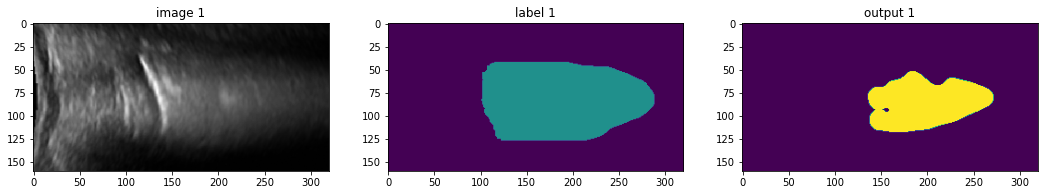

Number of not-sliding / sliding pixel = 0 6139
    Min thresh = 1000
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 215ns_image_610066411380_CLEAN.nii.gz


211s_iimage_3925135436261_clean.nii.gz


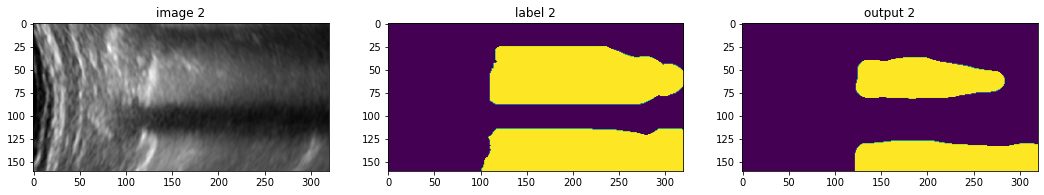

Number of not-sliding / sliding pixel = 0 11661
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


211s_iimage_3929217595322_clean.nii.gz


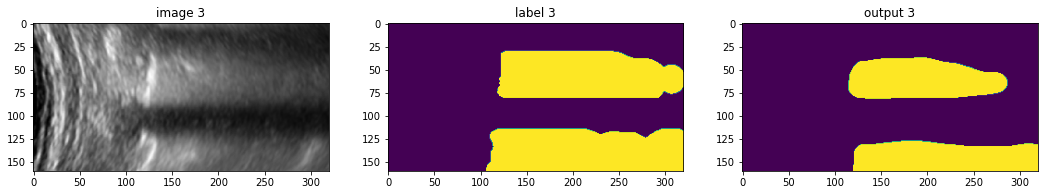

Number of not-sliding / sliding pixel = 0 12077
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 12 of 15


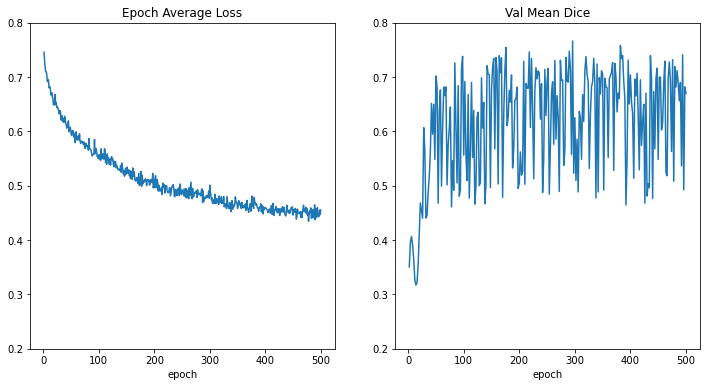

218ns_image_6056976176281_CLEAN.nii.gz


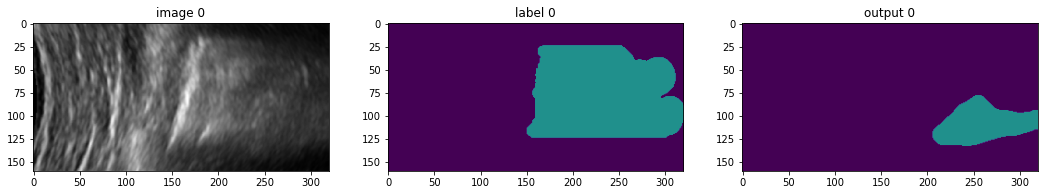

Number of not-sliding / sliding pixel = 3817 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


218ns_image_6370410622099_CLEAN.nii.gz


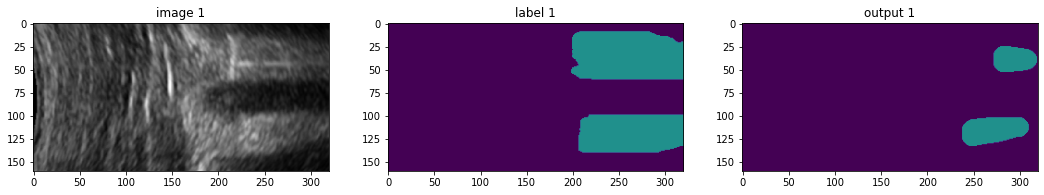

Number of not-sliding / sliding pixel = 2865 0
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


212s_iimage_128683942015128_CLEAN.nii.gz


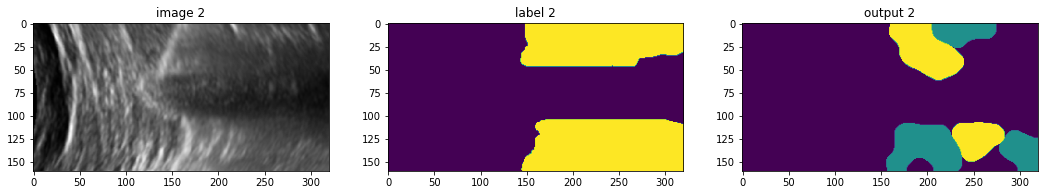

Number of not-sliding / sliding pixel = 6005 4868
    Min thresh = 1000
    Not Sliding = Fales Positive


  Winner = Not Sliding
 FP Patient = 212s_iimage_128683942015128_CLEAN.nii.gz


212s_iimage_128688523296793_CLEAN.nii.gz


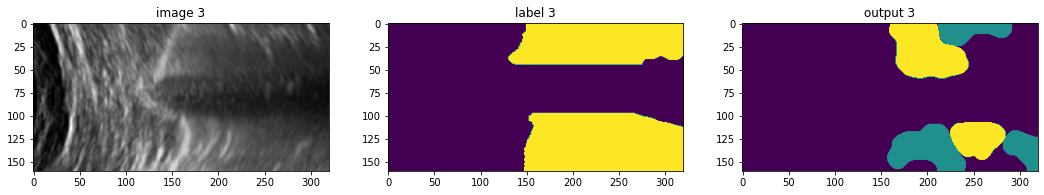

Number of not-sliding / sliding pixel = 5400 5596
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


212s_iimage_128692595484031_CLEAN.nii.gz


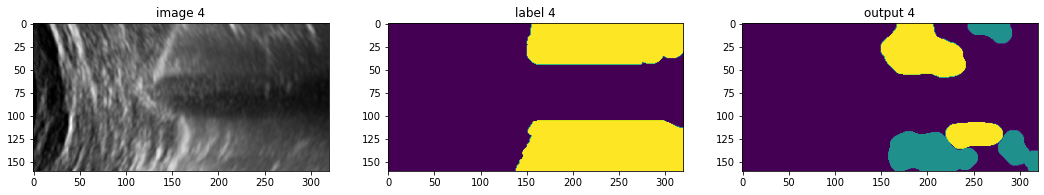

Number of not-sliding / sliding pixel = 5158 5427
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 13 of 15


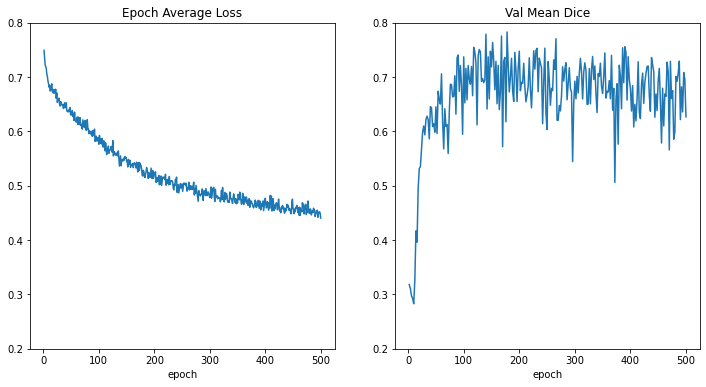

219ns_image_1884162273498_clean.nii.gz


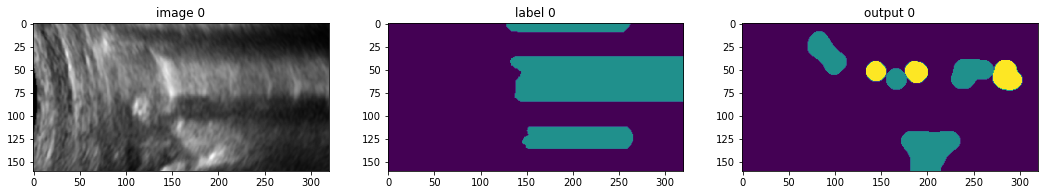

Number of not-sliding / sliding pixel = 4758 1668
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


219ns_image_1895283541879_clean.nii.gz


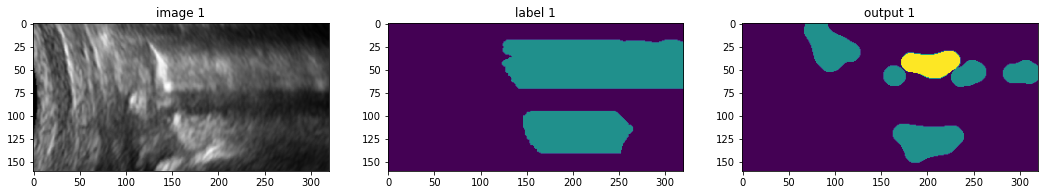

Number of not-sliding / sliding pixel = 6314 1412
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


224s_iimage_3308406916756_clean.nii.gz


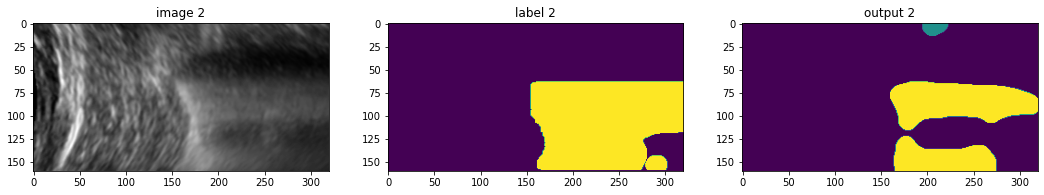

Number of not-sliding / sliding pixel = 313 8705
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


224s_iimage_3315947589826_clean.nii.gz


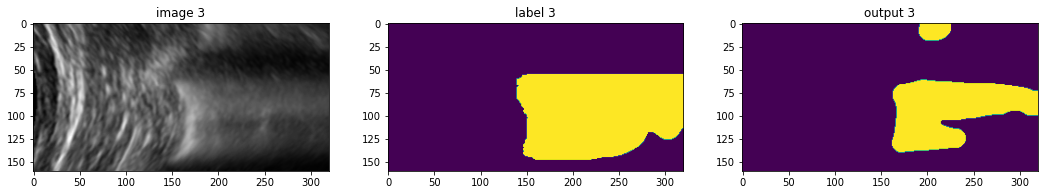

Number of not-sliding / sliding pixel = 0 8503
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


   VFOLD = 14 of 15


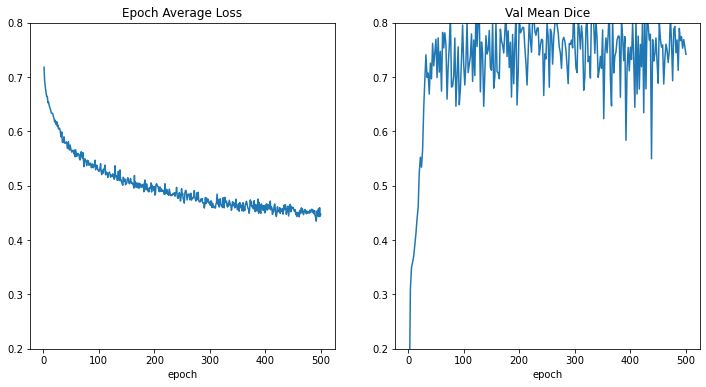

221ns_image_584357289931_clean.nii.gz


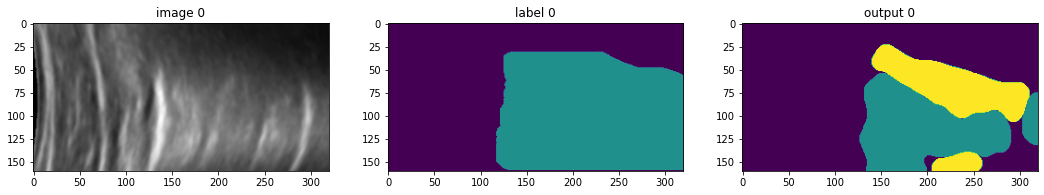

Number of not-sliding / sliding pixel = 11364 7469
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


221ns_image_588695055398_clean.nii.gz


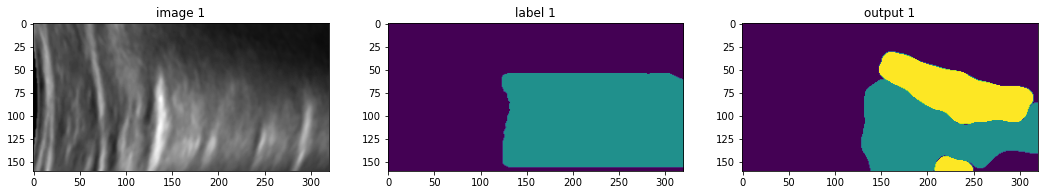

Number of not-sliding / sliding pixel = 11301 7332
    Min thresh = 1000
    Not Sliding = Correct


  Winner = Not Sliding


228s_iimage_3321463845606_clean.nii.gz


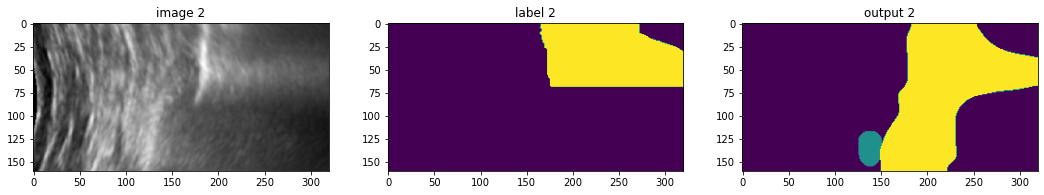

Number of not-sliding / sliding pixel = 798 15010
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding


228s_iimage_3384882513134_clean.nii.gz


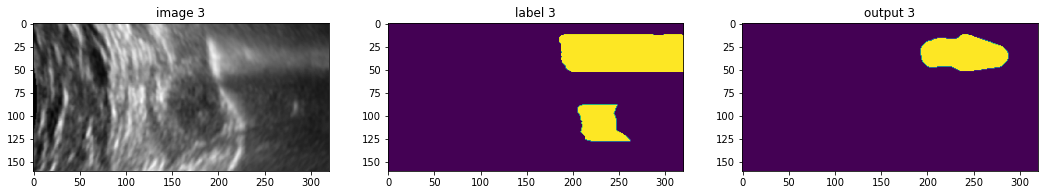

Number of not-sliding / sliding pixel = 0 2837
    Min thresh = 1000
    Sliding = Correct


  Winner = Sliding




Patients: Correct = 56 Incorrect = 6 Not Sliding as Sliding = 3
Slices: Correct = 55 Incorrect =  7 Not Sliding as Sliding = 3
*************


In [48]:
min_size = 1000
min_portion = 0.0

for prior in [[1.3,1.0,0.85]]: #[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
    print('*************')
    print("Prior =", prior)
    correct = 0
    incorrect = 0
    false_negatives = 0
    slice_correct = 0
    slice_incorrect = 0
    slice_false_negatives = 0
    for i in range(num_folds):
        (fcorrect, fincorrect, ffalse_negatives, fslice_correct, fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i],
            min_size, min_portion, prior, True)
        correct += fcorrect
        incorrect += fincorrect
        false_negatives += ffalse_negatives
        slice_correct += fslice_correct
        slice_incorrect += fslice_incorrect
        slice_false_negatives += fslice_false_negatives
    print()
    print()
    print("Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
    print("Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)
    print('*************')


In [2]:
import ipyparams
currentNotebook = ipyparams.notebook_name

from datetime import datetime
now = datetime.now()

experimentName = currentNotebook+now.strftime("-%Y.%m.%d_%H.%M.pdf")

cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

[NbConvertApp] Converting notebook ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb to pdf
[NbConvertApp] Support files will be in ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files/
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04_files
[NbConvertApp] Making directory ./ARUNet-3D-Middle-StdDevExtended-Extrud

[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3564361 bytes to ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-VFold-Test.ipynb-2021.11.30_02.04.pdf


0